In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.layers import Flatten, Dense, Activation
import matplotlib.pyplot as plt
from scipy.integrate import simps
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import visualkeras
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from PIL import Image
import pickle


## extracting_images , Data preprocessing and augmentation

In [20]:
dataset_dir=r"/home/gourav/Desktop/vss/capstone/dataset/train"
classes=['eyes-close','eyes-open']
input_shape = (224, 224, 3)
num_classes = 1
batch_size = 32
epochs = 650


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb', 
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'
)

Found 25015 images belonging to 2 classes.
Found 6253 images belonging to 2 classes.


## visualization of images

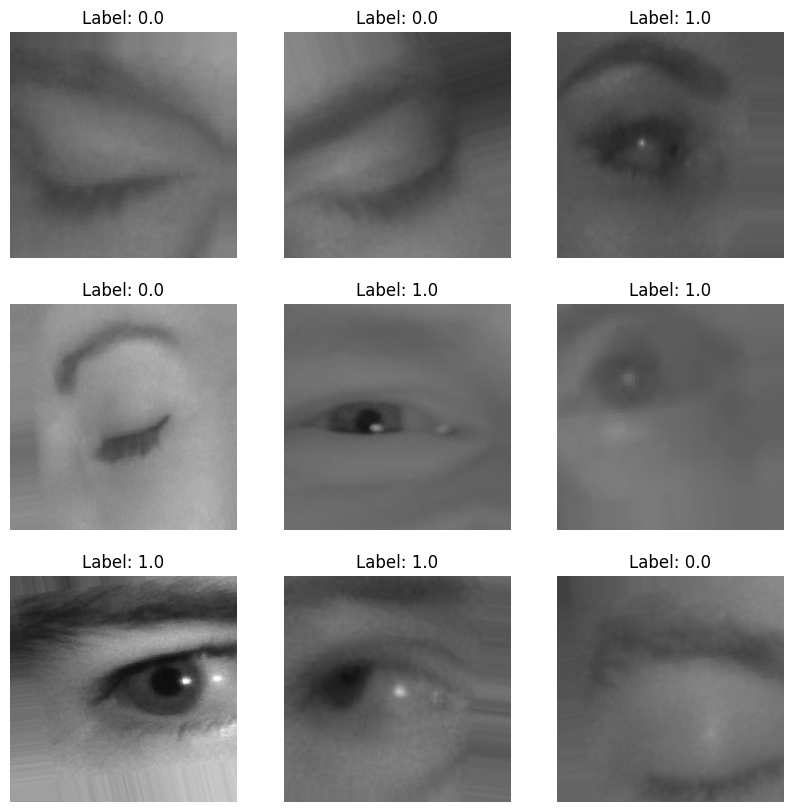

In [21]:
batch = next(train_generator)

images = batch[0] 
labels = batch[1] 

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray') 
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.show()


## model

In [22]:

base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
print(base_model.name)
for layer in base_model.layers[:-10]:
    layer.trainable = False

base_input = base_model.input
base_output = base_model.layers[-1].output  

x = GlobalAveragePooling2D()(base_output)  
x =Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
final_output = Dense(num_classes)(x) 

final_model = Model(inputs=base_input, outputs=final_output)

vgg16


## adding checkpoints

In [23]:
# checkpoint = ModelCheckpoint(
#     '/home/gourav/Desktop/vss/capstone/best_model_vgg_check.h5', 
#     monitor='val_binary_accuracy',                    
#     verbose=1,                                         
#     save_best_only=True,                               
#     mode='max'                                         
# )

## compiling time=820 minutes

In [24]:
final_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])

final_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [25]:
import tensorflow as tf

def check_cuda_tensorflow():
    # Check TensorFlow version
    print("TensorFlow version:", tf.__version__)
    
    # Check if TensorFlow can access GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        
        print("TensorFlow is using the following GPU(s):")
        for gpu in gpus:
            print(f" - {gpu}")
        
        # Optional: Print CUDA device properties
        for gpu in gpus:
            details = tf.config.experimental.get_device_details(gpu)
            print(details)
    else:
        print("No GPU available. TensorFlow is using the CPU.")

# Run the check
check_cuda_tensorflow()


TensorFlow version: 2.14.0
TensorFlow is using the following GPU(s):
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
{'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU'}


2024-06-20 04:40:37.286418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Training

In [26]:


history = final_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=50,
    )

Epoch 1/650
100/100 [==============================] - 84s 818ms/step - loss: 4.7962 - binary_accuracy: 0.7203 - precision_2: 0.9227 - recall_2: 0.5920 - auc_2: 0.7972 - val_loss: 4.2717 - val_binary_accuracy: 0.8044 - val_precision_2: 0.8109 - val_recall_2: 0.8947 - val_auc_2: 0.7988
Epoch 2/650
100/100 [==============================] - 102s 1s/step - loss: 3.3216 - binary_accuracy: 0.8766 - precision_2: 0.9678 - recall_2: 0.8262 - auc_2: 0.9146 - val_loss: 2.9453 - val_binary_accuracy: 0.8456 - val_precision_2: 0.8078 - val_recall_2: 0.9806 - val_auc_2: 0.8550
Epoch 3/650
100/100 [==============================] - 101s 1s/step - loss: 2.3231 - binary_accuracy: 0.9294 - precision_2: 0.9723 - recall_2: 0.9130 - auc_2: 0.9528 - val_loss: 2.1404 - val_binary_accuracy: 0.8150 - val_precision_2: 0.9607 - val_recall_2: 0.7340 - val_auc_2: 0.8807
Epoch 4/650
100/100 [==============================] - 98s 976ms/step - loss: 1.6851 - binary_accuracy: 0.9553 - precision_2: 0.9745 - recall_2: 0

In [27]:
with open('/home/gourav/Desktop/vss/capstone/history_vgg.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [28]:
final_model.save('best_driver_vgg.h5')

/home/gourav/anaconda3/envs/gpu2/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## model layers

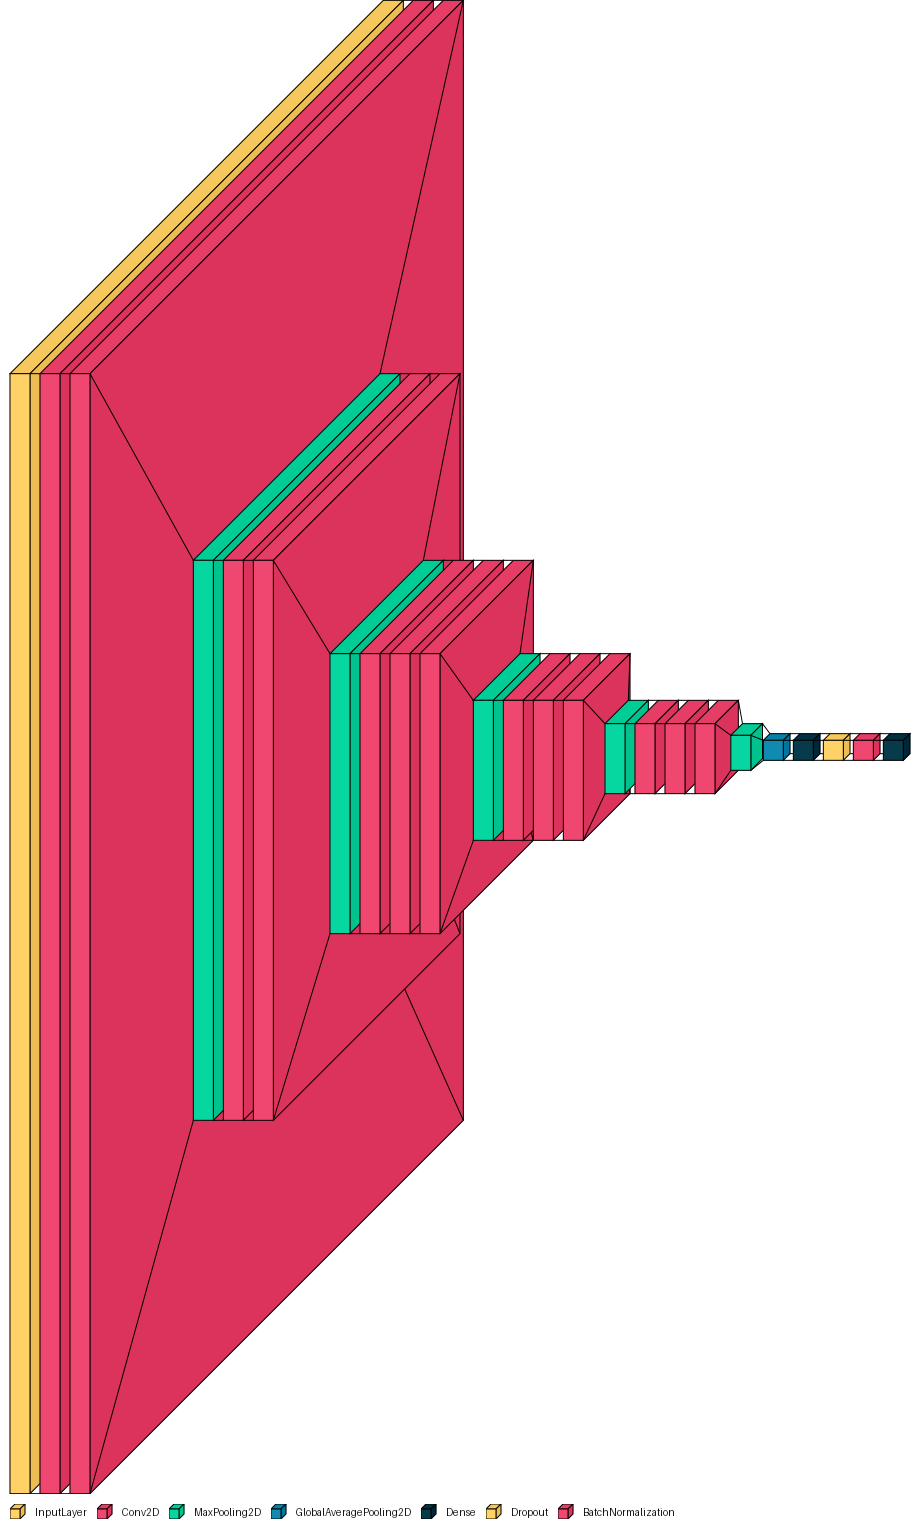

In [29]:

visualkeras.layered_view(final_model, 
                         scale_xy=5, 
                         scale_z=0.000001, 
                         max_z=100, 
                         legend=True,
                         font_color=(0, 0, 0))


## Testing 

In [31]:

    
model = keras.models.load_model('/home/gourav/Desktop/vss/capstone/best_driver_vgg.h5')
compiled_metrics = model.metrics

test_data_generator = ImageDataGenerator(rescale=1.0/255.0)  

test_generator = test_data_generator.flow_from_directory(
    '/home/gourav/Desktop/vss/capstone/dataset/test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False 
)

result = model.evaluate(test_generator)

print("Test Loss:", result[0])
print("Test Accuracy:", result[1])
print("Test Accuracy:", result[1]*100)

Found 1269 images belonging to 2 classes.
40/40 [==============================] - 6s 141ms/step - loss: 0.2558 - binary_accuracy: 0.9346 - precision_2: 0.9300 - recall_2: 0.9403 - auc_2: 0.9391
Test Loss: 0.255806028842926
Test Accuracy: 0.9345941543579102
Test Accuracy: 93.45941543579102


 ## Plotting training and validation loss over epochs

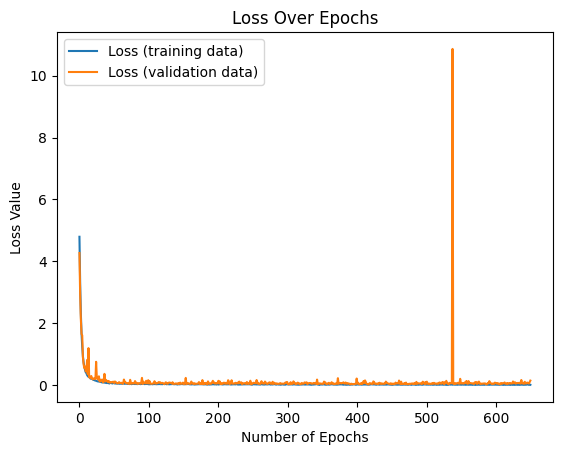

In [32]:

plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss Over Epochs')
plt.ylabel('Loss Value')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('Training-Validation_loss_v1_softplus_100_layer_4_original_data.png')
plt.show()


## accuracy

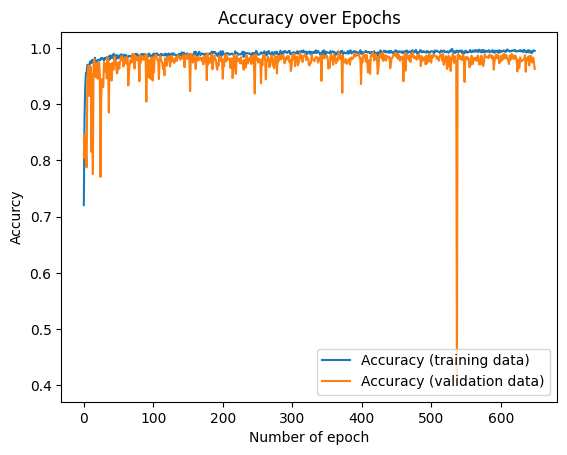

In [33]:
plt.plot(history.history['binary_accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_binary_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy over Epochs')
plt.ylabel('Accurcy')
plt.xlabel('Number of epoch')
plt.legend(loc="lower right")
plt.show()


## Confusion Matrix

40/40 [==============================] - 5s 123ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       633
           1       0.93      0.94      0.94       636

    accuracy                           0.93      1269
   macro avg       0.93      0.93      0.93      1269
weighted avg       0.93      0.93      0.93      1269


Confusion Matrix:
[[588  45]
 [ 38 598]]


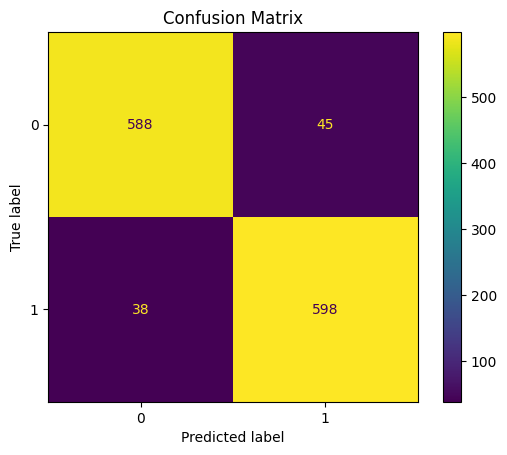

In [34]:
# Predictions
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype('int32').flatten()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plotting Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix')
plt.show()



In [35]:
# Detailed Accuracy Metrics
print("\nDetailed Accuracy Metrics:")
report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()), output_dict=True)
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"Class '{label}' - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-Score: {metrics['f1-score']:.2f}")


Detailed Accuracy Metrics:
Class 'eyes-close' - Precision: 0.94, Recall: 0.93, F1-Score: 0.93
Class 'eyes-open' - Precision: 0.93, Recall: 0.94, F1-Score: 0.94
Class 'macro avg' - Precision: 0.93, Recall: 0.93, F1-Score: 0.93
Class 'weighted avg' - Precision: 0.93, Recall: 0.93, F1-Score: 0.93


In [3]:
model = keras.models.load_model('/home/gourav/Desktop/vss/capstone/best_driver_vgg.h5')
# Save model in the saved_model format
SAVED_MODEL_DIR="/home/gourav/Desktop/vss/tensorrt/models/native_saved_model_vgg"
model.save(SAVED_MODEL_DIR)

2024-08-22 13:48:52.654743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 13:48:52.684969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 13:48:52.685236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Assets written to: /home/gourav/Desktop/vss/tensorrt/models/native_saved_model_vgg/assets


INFO:tensorflow:Assets written to: /home/gourav/Desktop/vss/tensorrt/models/native_saved_model_vgg/assets
